In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Large-scale power loss in ground-based CMB mapmaking
Naess, Sigurd ; Louis, Thibaut



In [2]:
npix = 10
nsamp = 100
pix = np.arange(nsamp).astype(float)*npix/nsamp
#A standard nearest-neighbor pointing matrix for this looks like:

P = np.zeros((nsamp,npix))
for i, p in enumerate(pix):
    P[i,int(np.round(pix[i]))%npix] = 1


freq = np.fft.rfftfreq(nsamp)
print(freq)
inv_ps = 1/(1+(np.maximum(freq,freq[1]/2)/0.03)**-3.5)
F = np.zeros((nsamp,nsamp))
I = np.eye(nsamp)
for i in range(nsamp):
    F[:,i] = np.fft.irfft(inv_ps*np.fft.rfft(I[i]), n=nsamp)
#The signal itself consists of just a long-wavelength sine wave:5
print(F[0,0],F[99,99])
signal = np.sin(2*np.pi*pix/npix)


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
0.931157641667902 0.931157641667902


Text(0, 0.5, '$t_2$')

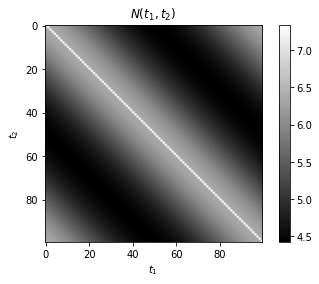

In [3]:
plt.imshow(np.linalg.inv(F), cmap='gray')  # Use 'gray' for grayscale images, or other colormaps
plt.colorbar()  # Add a colorbar to show the value mapping
plt.title('$N(t_1,t_2)$')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')


Text(0, 0.5, 'Signal')

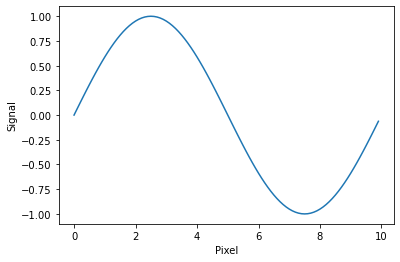

In [4]:
plt.plot(pix,signal)
plt.xlabel('Pixel')
plt.ylabel('Signal')
#plt.plot(range(nsamp),pix)

Text(0.5, 0, 'Time')

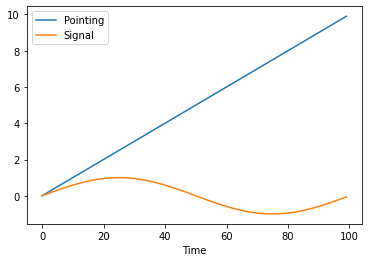

In [5]:
plt.plot(range(nsamp),pix,label='Pointing')
plt.plot(range(nsamp),signal,label='Signal')
plt.legend()
plt.xlabel('Time')

In [6]:
map_binned = np.linalg.solve((P.T.dot(P)), P.T.dot(signal)) ## Solves P^TP (map) = P^T data
map_ml = np.linalg.solve((P.T.dot(F).dot(P)),P.T.dot(F.dot(signal)))
map_fb = np.linalg.solve(P.T.dot(P), P.T.dot(F).dot(signal))
obsmat = np.linalg.inv(P.T.dot(P)).dot(P.T.dot(F).dot(P))
#and using it, we can define a debiased filter+bin map

map_fb_deobs = np.linalg.solve(obsmat, map_fb)

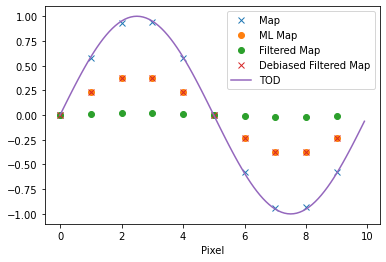

In [7]:
plt.plot(range(npix),map_binned,'x',label='Map')
plt.plot(range(npix),map_ml,'o',label='ML Map')
plt.plot(range(npix),map_fb,'o',label='Filtered Map')
plt.plot(range(npix),map_fb_deobs,'x',label='Debiased Filtered Map')
plt.plot(pix,signal,label='TOD')
plt.xlabel('Pixel')
plt.legend()

## Signal To Noise

In [8]:
# First look at the signal to noise from the above example. Take the signal in each pixel to be the mean of all samples in that pixel.
# What is called signal there is really the data. So add noise to the signal


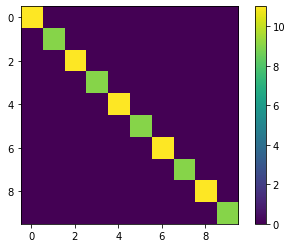

In [9]:
plt.imshow(P.T.dot(P))
plt.colorbar()

In [10]:
for i in range(npix):
    print(P.T.dot(P)[i,i])

11.0
9.0
11.0
9.0
11.0
9.0
11.0
9.0
11.0
9.0


In [11]:

# Define the mean (zero vector)
mean = np.zeros(nsamp)

# Define a random covariance matrix N (must be positive semi-definite)
# Example: Generating a symmetric positive-definite matrix
A = np.random.randn(nsamp, nsamp)
N = np.linalg.inv(F)

# Draw 100 samples from the multivariate normal distribution
noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)




In [12]:
data=signal+noise
data_map_binned = np.linalg.solve((P.T.dot(P)), P.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((P.T.dot(F).dot(P)),P.T.dot(F.dot(data)))

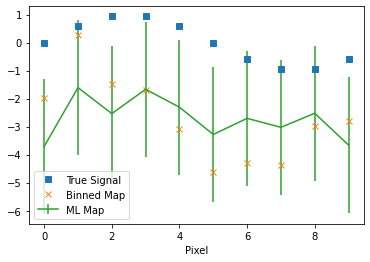

In [13]:
plt.plot(range(npix),map_binned,'s',label='True Signal')
plt.plot(range(npix),data_map_binned,'x',label='Binned Map')
error=np.sqrt(np.diag(np.linalg.inv(P.T.dot(F).dot(P))))
plt.errorbar(range(npix),data_map_ml,yerr=error,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

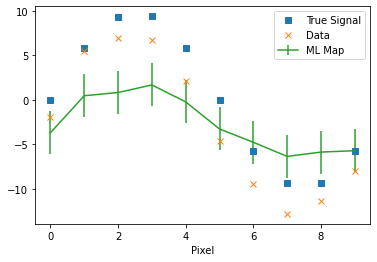

In [14]:
## Suppose the signal to noise is much larger: 
sn=10
signal = sn*np.sin(2*np.pi*pix/npix)
data=signal+noise
data_map_binned = np.linalg.solve((P.T.dot(P)), P.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((P.T.dot(F).dot(P)),P.T.dot(F.dot(data)))
plt.plot(range(npix),sn*map_binned,'s',label='True Signal')
plt.plot(range(npix),data_map_binned,'x',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(P.T.dot(F).dot(P))))
plt.errorbar(range(npix),data_map_ml,yerr=error,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

In [15]:
sigma = 0.5  # Beam width in pixel units
Pw = np.zeros((nsamp, npix))

for i, p in enumerate(pix):
    for j in range(npix):
        Pw[i, j] = np.exp(-0.5 * ((p - j) / sigma) ** 2)  # Gaussian weight

    Pw[i, :] /= np.sum(Pw[i, :])  # Normalize row to sum to 1

print(Pw[:5])


[[8.80536890e-01 1.19167709e-01 2.95387219e-04 1.34105590e-08
  1.11512649e-14 1.69833539e-22 4.73745239e-32 2.42040660e-43
  2.26492524e-56 3.88187447e-71]
 [8.31501844e-01 1.67877327e-01 6.20787476e-04 4.20451514e-08
  5.21568034e-14 1.18502656e-21 4.93136645e-31 3.75862103e-42
  5.24700979e-55 1.34158219e-69]
 [7.67544570e-01 2.31179982e-01 1.27531926e-03 1.28857495e-07
  2.38463835e-13 8.08271817e-21 5.01781239e-30 5.70549693e-41
  1.18821383e-53 4.53229119e-68]
 [6.88218275e-01 3.09236404e-01 2.54493739e-03 3.83606238e-07
  1.05904958e-12 5.35511741e-20 4.95956713e-29 8.41280111e-40
  2.61372290e-52 1.48730671e-66]
 [5.95751703e-01 3.99344309e-01 4.90288582e-03 1.10249881e-06
  4.54073917e-12 3.42528768e-19 4.73248909e-28 1.19757925e-38
  5.55061337e-51 4.71194013e-65]]


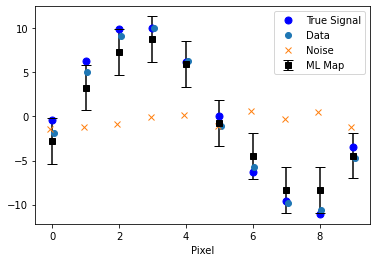

In [16]:
sn=10
signal = sn*np.sin(2*np.pi*pix/npix)
noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)
data=signal+noise

map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
noise_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(noise)) ## Solves P^TP (map) = P^T data
data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),map_binned,'ob',ms=7,label='True Signal')
plt.plot(np.arange(0,npix)+.05,data_map_binned,'o',label='Data')
plt.plot(np.arange(0,npix)-.05,noise_binned,'x',label='Noise')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

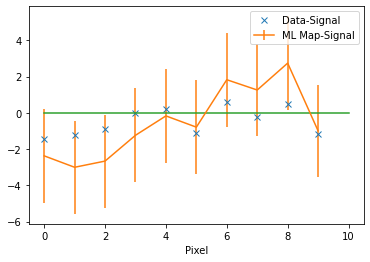

In [17]:
plt.plot(range(npix),(data_map_binned-map_binned),'x',label='Data-Signal')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),(data_map_ml-map_binned),yerr=error,label='ML Map-Signal')
plt.plot([0,10],[0,0])
plt.xlabel('Pixel')
plt.legend()

-0.0006645058264370434 -0.006250740505520333
1.1613472486398106 1.121139106211945


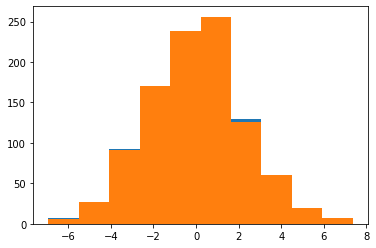

In [18]:
#do a bunch of noise simulations and see how well each estimator does
sn=1
signal = sn*np.sin(2*np.pi*pix/npix)
mean = np.zeros(nsamp)
nsim=1000
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
for i in range(nsim):
    noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)
    data=signal+noise
    map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-map_binned
    data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml-map_binned
    delta.append(d2[0])
    deltb.append(d1[0])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
#print(bstd)
plt.hist(bmean)
plt.hist(mlmean)
print(np.mean(bmean),np.mean(mlmean))
print(np.mean(bstd),np.mean(mlstd))
    

In [19]:
# How does this compare to the expected error on the ML Map?
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
print(error)

[2.60920711 2.57216429 2.56795335 2.58556986 2.6003505  2.60124246
 2.58940325 2.5618362  2.58539925 2.53136464]


In [20]:
# It's not quite the same thing, as the historgramed stuff is the std of all 10 points from the "truth" while the 
# predicted noise is the predicted std for one point
print(np.std(delta),np.std(deltb))

2.5351997904715264 2.545089135940185


So the std of the accuracy of the prediction of any one pixel is much larger than the scatter of the mean of all pixels across many simulations. This is because the pixel noise is very correlated,
so if one pixel has large noise so will all the others and all will give a similarly biased high estimate of the signal. So the std of those 10 estimates will be smaller. Probably best then to use the individual pixels std as a benchmark.

## Add in more detectors

In [93]:
import numpy as np

# Define simulation parameters
nsamp = 1000  # Number of time samples
npix = 200   # Number of sky pixels
N_det = 3    # Number of detectors
det_spacing = 1  # Separation between detectors in pixels
sigma = 0.5  # Beam width in pixel units

# Simulated pointing locations for the first detector
pix = np.linspace(0, 100, nsamp)  # Example: Detector sweeps across pixels
signal=np.zeros(nsamp*N_det)
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

# Fill the pointing matrix
for d, offset in enumerate(detector_offsets):  # Loop over detectors
    for i, p in enumerate(pix):  # Loop over time samples
        index = i + d * nsamp  # New index for multiple detectors
        for j in range(npix):  # Loop over sky pixels
            Pw[index, j] = np.exp(-0.5 * ((p + offset - j) / sigma) ** 2)  # Gaussian weight
            THIS MIGHT BE WRONG; need to put in offset signal
            signal[index] = np.sin(2*np.pi*pix[i]/npix)
        Pw[index, :] /= np.sum(Pw[index, :])  # Normalize row to sum to 1

# Pw now has shape (nsamp * N_det, npix), meaning all detectors are included


## Signal and Noise
Need to generate 3 copies for the 3 different detectors, so signal has size nsamp*3

In [92]:
freq = np.fft.rfftfreq(nsamp)
inv_ps = 1/(1+(np.maximum(freq,freq[1]/2)/0.03)**-3.5)
F = np.zeros((nsamp*N_det,nsamp*N_det))
I = np.eye(nsamp)
for d in range(N_det):
    for i in range(nsamp):
        F[nsamp*d:nsamp*(d+1),i+N_det*d] = np.fft.irfft(inv_ps*np.fft.rfft(I[i]), n=nsamp)
#The signal itself consists of just a long-wavelength sine wave:5
print(F[0,0],F[99,99])


0.9311369154234842 0.9311369154234842


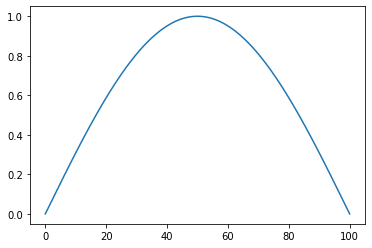

In [98]:
#plt.plot(pix,signal[:nsamp])
#plt.plot(pix,signal[nsamp:2*nsamp])
plt.plot(pix,signal[2*nsamp:])

Text(0, 0.5, '$t_2$')

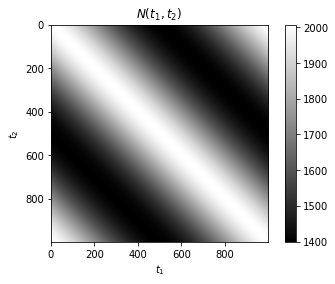

In [82]:
plt.imshow(np.linalg.inv(F), cmap='gray')  # Use 'gray' for grayscale images, or other colormaps
plt.colorbar()  # Add a colorbar to show the value mapping
plt.title('$N(t_1,t_2)$')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')

1689.5589585740693


Text(0.5, 1.0, 'Number of Samples')

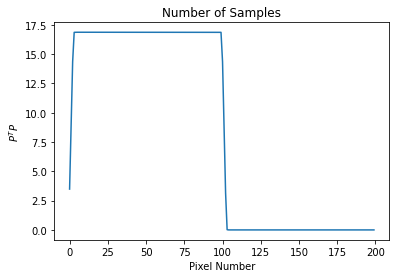

In [83]:
plt.plot(range(npix),np.diag(Pw.T.dot(Pw)))
print(np.sum(np.diag(Pw.T.dot(Pw))))
plt.xlabel('Pixel Number')
plt.ylabel('$P^TP$')
plt.title('Number of Samples')
## The total number of samples is 1000*3=3000; spread across 200 pixels 
## leaves 15 samples per pixel, but since they are weighted some of the weight is lost outside 
## the 200

In [84]:
print(np.sum(Pw[:,0]))
## This is the number of times pixel 0 is hit
print(np.sum(Pw[:,1]))

5.89391783122319
15.54536762852786


In [85]:
print(Pw[:20,0],np.sum(Pw[:20,0]))

[8.80536890e-01 8.31445531e-01 7.67400876e-01 6.87958363e-01
 5.95361242e-01 4.94951664e-01 3.94260817e-01 3.00925317e-01
 2.20546552e-01 1.55660262e-01 1.06052971e-01 6.98060512e-02
 4.43411158e-02 2.71066979e-02 1.58933355e-02 8.91237661e-03
 4.77468444e-03 2.44658827e-03 1.20249158e-03 5.68834190e-04] 5.610152660812446


In [86]:
## So pixel 0 is hit mosty by detector 0
indices = np.where(Pw[:,0] > .001)
print(indices, Pw[Pw > .001])


(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18, 1000, 1001, 1002,
       1003, 1004, 1005, 1006, 1007, 1008]),) [0.88053689 0.11916771 0.83144553 ... 0.10645077 0.78657071 0.10645077]


In [88]:
#So the first detector hts it most often and the second detector a little bit
mean = np.zeros(nsamp)
sn=10
signal = sn*np.sin(2*np.pi*pix/npix)
N = np.linalg.inv(F)
noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)
data=signal+noise

print(np.shape(Pw),np.shape(signal),np.shape(N))
map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
noise_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(noise)) ## Solves P^TP (map) = P^T data
data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),map_binned,'ob',ms=7,label='True Signal')
plt.plot(np.arange(0,npix)+.05,data_map_binned,'o',label='Data')
plt.plot(np.arange(0,npix)-.05,noise_binned,'x',label='Noise')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

(3000, 200) (1000,) (1000, 1000)


ValueError: shapes (200,3000) and (1000,) not aligned: 3000 (dim 1) != 1000 (dim 0)